# M1. Actividad

### Daniel Emilio Fuentes Portaluppi - A01708302

# Instrucciones

Para este problema, deberás entregar, de manera individual, un informe en PDF que estudie las estadísticas de un robot de limpieza reactivo, así como el enlace al repositorio en Github del código desarrollado para esta actividad. El código debe ajustarse al estilo solicita en el siguiente documento.

**Dado:**

* Habitación de MxN espacios.
* Número de agentes.
* Porcentaje de celdas inicialmente sucias.
* Tiempo máximo de ejecución.

**Realiza la siguiente simulación:**

* Inicializa las celdas sucias (ubicaciones aleatorias).
* Todos los agentes empiezan en la celda [1,1].
* En cada paso de tiempo:
    * Si la celda está sucia, entonces aspira.
    * Si la celda está limpia, el agente elije una dirección aleatoria para moverse (unas de las 8 celdas vecinas) y elije la acción de movimiento (si no puede moverse allí, permanecerá en la misma celda).
* Se ejecuta el tiempo máximo establecido.



In [1]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que todos los agentes inicien en una celda, elegimos ''MultiGrid''.
from mesa.space import MultiGrid

# Con ''RandomActivation, hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import SimultaneousActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos 'random' para generar números aleatorios.
import random

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [2]:
# Definimos la clase ''CleaningAgent'' que hereda de ''Agent''.
# Esta clase define el comportamiento de los agentes que van a limpiar el piso.
class CleaningAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        
    # Definimos el método ''move'' que permite a los agentes moverse a una celda vacía.
    def move(self):
        possible_cells = self.model.grid.get_neighborhood(
            self.pos,
            moore = True,
            include_center=False)
        
        empty_cells = [cell for cell in possible_cells if self.model.grid.is_cell_empty(cell)]

        if empty_cells:
            new_position = random.choice(empty_cells)
            self.model.grid.move_agent(self, new_position)

    # Definimos el método ''step'' que permite a los agentes moverse y limpiar el piso.
    def step(self):
        x, y = self.pos
        if self.model.floor[x][y] == 1:
            self.model.floor[x][y] = 0
        else:
            self.move()

In [3]:
# Definimos la función ''get_agents'' que nos permite obtener la posición de los agentes.
def get_agents(Model):
    agents = np.zeros((Model.grid.width, Model.grid.height))
    for cell in Model.grid.coord_iter():
        cell_content, (x, y) = cell
        if len(cell_content) > 0:
            agents[x][y] = 1

    return agents

# Definimos la función ''get_clean_percentage'' que nos permite obtener el porcentaje de piso limpio.
def get_clean_percentage(Model):
    return Model.floor.sum() / Model.floor.size * 100    

In [4]:
# Definimos la clase ''CleaningModel'' que hereda de ''Model''.
# Esta clase define el entorno donde se van a mover los agentes,
# además de definir el número de agentes y el porcentaje de celdas sucias.
class CleaningModel(Model):
    def __init__(self, num_agents, width, height, percentage_dirty, render = False):
        self.grid = MultiGrid(width, height, torus = False)
        self.floor = np.zeros((width, height))
        self.schedule = SimultaneousActivation(self)


        reporters = {"CleanPercentage": get_clean_percentage}

        if render:
            reporters["Dirt"] = lambda m: self.floor.copy()
            reporters["Agents"] = get_agents

        self.datacollector = DataCollector(model_reporters=reporters)
        self.running = True
        self.hundred_steps = 0
        self.thousand_steps = 0
        self.tenThousand_steps = 0

        # Creamos los agentes y los colocamos en la celda (1, 1).
        for i in range(num_agents):
            a = CleaningAgent(i, self)
            self.schedule.add(a)
            self.grid.place_agent(a, (1, 1))

        # Colocamos suciedad de manera aleatoria en el piso.
        for i in range(width):
            for j in range(height):
                if random.random() < percentage_dirty:
                    self.floor[i][j] = 1

    # Definimos el método ''step'' que va a guardar la información de cada paso de la simulación.
    # Además, detiene la simulación cuando todas las celdas están limpias.
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

        if np.sum(self.floor) == 0:
            self.running = False

# Animación
5 agentes en una habitación de 20x20 con 90% de celdas sucias.

In [5]:
# Definimos los parámetros que se van a usar en la simulación.
WIDTH = 20
HEIGHT = 20
PERCENTAGE_DIRTY = 0.9
NUM_AGENTS = 5

In [6]:
# Creamos una instancia de la clase ''CleaningModel''. Y ejecutamos la simulación.
model = CleaningModel(NUM_AGENTS, WIDTH, HEIGHT, PERCENTAGE_DIRTY, render = True)
while model.running: 
    model.step()

# Variable que recolecta la información de cada paso de la simulación.
all_grid = model.datacollector.get_model_vars_dataframe()

In [7]:
fig, axs = plt.subplots(figsize=(5,5))

axs.set_xticks([])
axs.set_yticks([])

floors = all_grid.get('Dirt')
agents = all_grid.get('Agents')

data = floors + (4 * agents)

patch = axs.imshow(data[0], cmap='Greys')
plt.close()

def animate(i):
    patch.set_data(data[i])

anim = animation.FuncAnimation(fig, animate, frames=model.schedule.steps, interval=100)

anim

In [8]:
print("Tomaron", model.schedule.steps, "pasos para limpiar el piso.")

Tomaron 1073 pasos para limpiar el piso.


### Para un espacio de 100x100, considera los siguientes escenarios:

In [9]:
# Definimos los parámetros que se van a usar en la simulación.
WIDTH = 100
HEIGHT = 100

# Escenario 1
1 agente y el 90% de las celdas sucias.

In [10]:
PERCENTAGE_DIRTY = 0.9
NUM_AGENTS = 1

# Creamos una instancia de la clase ''CleaningModel''. Y ejecutamos la simulación.
model = CleaningModel(NUM_AGENTS, WIDTH, HEIGHT, PERCENTAGE_DIRTY)
while model.running: 
    model.step()

# Variable que recolecta la información de cada paso de la simulación.
all_grid = model.datacollector.get_model_vars_dataframe()

¿Cuántos pasos de simulación toma limpiar todo el espacio?

In [11]:
print("Tomó", model.schedule.steps, "pasos para limpiar el piso.")

Tomó 371170 pasos para limpiar el piso.


¿Qué porcentaje de celdas sucias queda con los siguientes pasos de simulación: 100, 1000, 10000?

In [12]:
print(f"Porcentaje de celdas sucias restantes después de 100 pasos: {all_grid['CleanPercentage'][100]:.2f}%")
print(f"Porcentaje de celdas sucias restantes después de 1000 pasos: {all_grid['CleanPercentage'][1000]:.2f}%")
print(f"Porcentaje de celdas sucias restantes después de 10000 pasos: {all_grid['CleanPercentage'][10000]:.2f}%")

Porcentaje de celdas sucias restantes después de 100 pasos: 89.27%
Porcentaje de celdas sucias restantes después de 1000 pasos: 86.40%
Porcentaje de celdas sucias restantes después de 10000 pasos: 71.59%


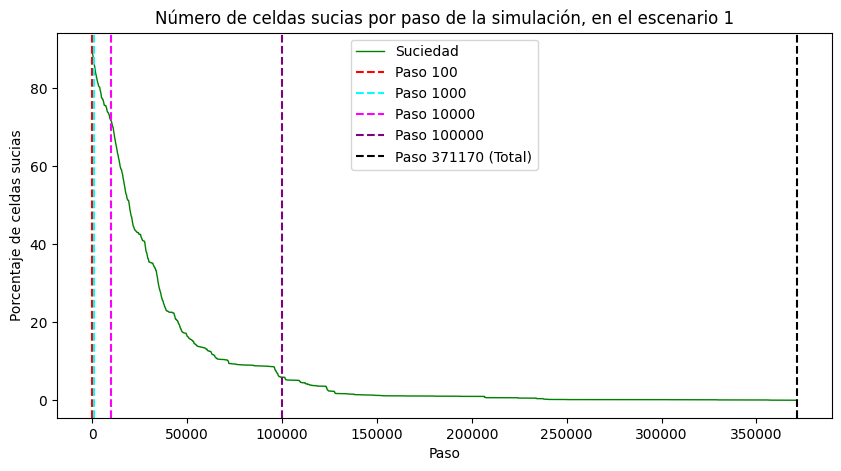

In [13]:
# Grafica del número de celdas sucias por paso de la simulación.
plt.figure(figsize=(10, 5))
plt.plot(all_grid.CleanPercentage, linewidth=1, color="green", label="Suciedad")
plt.xlabel("Paso")
plt.ylabel("Porcentaje de celdas sucias")
plt.title("Número de celdas sucias por paso de la simulación, en el escenario 1")

# Líneas verticales para los pasos específicos.
plt.axvline(x=100, color='red', linestyle='--', label='Paso 100')
plt.axvline(x=1000, color='cyan', linestyle='--', label='Paso 1000')
plt.axvline(x=10000, color='magenta', linestyle='--', label='Paso 10000')
plt.axvline(x=100000, color='purple', linestyle='--', label='Paso 100000')
plt.axvline(x=model.schedule.steps, color='black', linestyle='--', label=f'Paso {model.schedule.steps} (Total)')

plt.legend()
plt.show()

# Escenario 2
2 agentes y el 90% de las celdas sucias.

In [14]:
PERCENTAGE_DIRTY = 0.9
NUM_AGENTS = 2

# Creamos una instancia de la clase ''CleaningModel''. Y ejecutamos la simulación.
model = CleaningModel(NUM_AGENTS, WIDTH, HEIGHT, PERCENTAGE_DIRTY)
while model.running: 
    model.step()

# Variable que recolecta la información de cada paso de la simulación.
all_grid = model.datacollector.get_model_vars_dataframe()

¿Cuántos pasos de simulación toma limpiar todo el espacio?

In [15]:
print("Tomaron", model.schedule.steps, "pasos para limpiar el piso.")

Tomaron 146687 pasos para limpiar el piso.


¿Qué porcentaje de celdas sucias queda con los siguientes pasos de simulación: 100, 1000, 10000?

In [16]:
print(f"Porcentaje de celdas sucias restantes después de 100 pasos: {all_grid['CleanPercentage'][100]:.2f}%")
print(f"Porcentaje de celdas sucias restantes después de 1000 pasos: {all_grid['CleanPercentage'][1000]:.2f}%")
print(f"Porcentaje de celdas sucias restantes después de 10000 pasos: {all_grid['CleanPercentage'][10000]:.2f}%")

Porcentaje de celdas sucias restantes después de 100 pasos: 88.92%
Porcentaje de celdas sucias restantes después de 1000 pasos: 84.71%
Porcentaje de celdas sucias restantes después de 10000 pasos: 51.30%


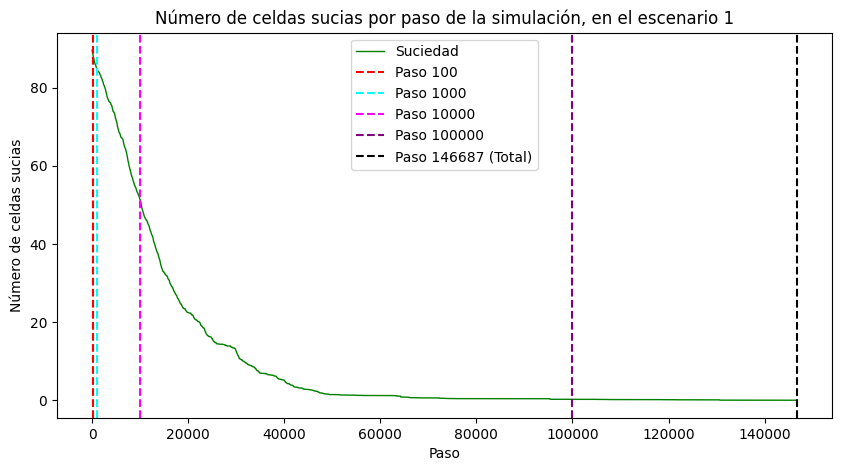

In [17]:
# Grafica del número de celdas sucias por paso de la simulación.
plt.figure(figsize=(10, 5))
plt.plot(all_grid.CleanPercentage, linewidth=1, color="green", label="Suciedad")
plt.xlabel("Paso")
plt.ylabel("Número de celdas sucias")
plt.title("Número de celdas sucias por paso de la simulación, en el escenario 1")

# Líneas verticales para los pasos específicos.
plt.axvline(x=100, color='red', linestyle='--', label='Paso 100')
plt.axvline(x=1000, color='cyan', linestyle='--', label='Paso 1000')
plt.axvline(x=10000, color='magenta', linestyle='--', label='Paso 10000')
plt.axvline(x=100000, color='purple', linestyle='--', label='Paso 100000')
plt.axvline(x=model.schedule.steps, color='black', linestyle='--', label=f'Paso {model.schedule.steps} (Total)')

plt.legend()
plt.show()

# Cantidad óptima de aspiradoras
¿Cuál es la cantidad óptima de aspiradoras para limpiar el 90% de las celdas sucias en un espacio de 100x100?
<br>Considerando que el máximo número de aspiradoras es 10.

In [18]:
# Definimos una lista de agentes de limpieza de 1 a 10.
AgentCounts = range(1, 11)
results = []

# Ejecutamos 5 veces la simulación para cada número de agentes.
for i in range (5):
    for count in AgentCounts:
        model = CleaningModel(count, WIDTH, HEIGHT, PERCENTAGE_DIRTY)
        while model.running: 
            model.step()
        results.append((count, model.schedule.steps))

results_df = pd.DataFrame(results, columns=["AgentCount", "Steps"])
results_grouped = results_df.groupby("AgentCount").mean().reset_index()


In [19]:
results_grouped

AgentCount     Steps
0           1  312161.2
1           2  144254.6
2           3  118100.4
3           4   89051.2
4           5   60274.8
5           6   52032.4
6           7   46286.0
7           8   35517.6
8           9   37534.8
9          10   39338.4

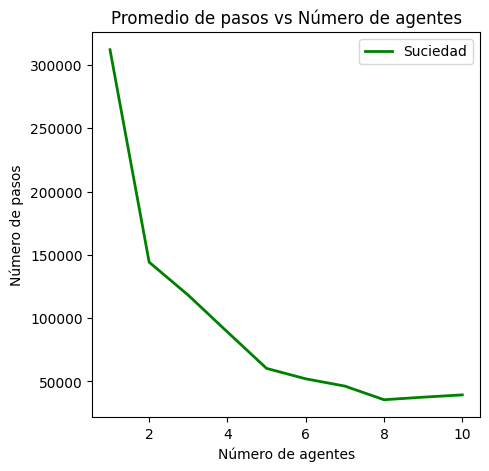

In [20]:
plt.figure(figsize=(5, 5))
plt.plot(results_grouped.AgentCount, results_grouped.Steps, linewidth=2, color="green", label="Suciedad")
plt.xlabel("Número de agentes")
plt.ylabel("Número de pasos")
plt.title("Promedio de pasos vs Número de agentes")
plt.legend()
plt.show()

## Conclusión
Para este último punto se corrieron 5 simulaciones para cada cantidad de aspiradoras/agentes, y se obtuvo el promedio de pasos que tomó limpiar el 90% de las celdas sucias.
<br> Aunque de primera mano se puede esperar que 10 aspiradoras sean la cantidad óptima, se puede observar que a 8 aspiradoras en promedio les tómo menos pasos limpiar el 90% de las celdas sucias.
<br> Al final este resultado podría variar con más simulaciones, ya que si se ejecuta de nuevo este escenario, 10 o inclusive 9 aspiradoras podrían ser las que tomen menos tiempo en limpiar el 90% de las celdas sucias. Pero en este caso al momento de escribir esta conclusión, <b>8 aspiradoras</b> fueron las más eficientes.

Concluyendo en general con la actividad, fue interesante entender mejor el funcionamiento de los agentes, y ver como los diferentes parámetros afectan el comportamiento de los mismos.
Lo que es obvio es que a 1 agente le toma demasiado tiempo limpiar el 90% de las celdas sucias, pero lo que más me impresionó fue cómo llegaban a variar los pasos pudiendo ser de 220000 aprox hasta casi 350000.
<br>Otra cosa que me llamó la atención fue la diferencia tan grande que genera un agente más pasando de 1 a 2, después de eso la diferencia ya no es tan grande y solo va disminuyendo poco a poco.
<br><br>Creo que lo visto en esta actividad será muy útil para la elaboración de nuestra situación problema.